In [1]:
import cv2
import os
import numpy as np
from PIL import Image
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from mtcnn.mtcnn import MTCNN
import keras_metrics
from keras.applications import VGG19,ResNet50
from keras.models import Sequential,load_model
from keras.layers import Flatten,BatchNormalization,Dense,Dropout,Input
from sklearn.preprocessing import OneHotEncoder

In [2]:
import warnings
warnings.filterwarnings(action="ignore")

In [3]:
plt.style.use('fivethirtyeight')


In [4]:
# function to extract faces 
def get_faces(image_name,target_shape=(160,160)):
    face_list = []
    # open image
    image = Image.open(image_name)
    # Covert it to RGB
    image = image.convert("RGB")
    # convert image to array
    image = np.asarray(image)
    face_detector = MTCNN()
    # detect faces
    results = face_detector.detect_faces(image)
    # Go through every detecte face and save it
    for i in range(len(results)):
        x1, y1, width, height = results[i]['box']
        x1, y1 = abs(x1), abs(y1)
        x2, y2 = x1 + width, y1 + height
        face = image[y1:y2, x1:x2]
        # resize pixels to the model size
        img = Image.fromarray(face)
        img = img.resize(target_shape)
        face_array = np.asarray(img)
        face_list.append(face_array)
    return face_list

In [5]:
def load_data(directory_name):
    X,y = [],[]
    for sub in os.listdir(directory_name):
        current_path = directory_name + "/" + sub + "/"
        for image_name in os.listdir(current_path):
            image_name = current_path + image_name
    
            faces = get_faces(image_name)
            for i in range(len(faces)):
                X.append(faces[i])
                y.append(sub)
    return np.asarray(X),np.asarray(y)

In [6]:
trainX, trainy = load_data(r"data\train")
testX, testy = load_data("data/val")

# Model comparison

## Creating embedded images

In [7]:
# Loading facenet model
model_facenet = load_model("facenet_keras.h5")

In [8]:
# get the face embedding for one face
def get_embedding(model, face_pixels):
    # scale pixel values
    face_pixels = face_pixels.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = np.expand_dims(face_pixels, axis=0)
    # make prediction to get embedding
    yhat = model.predict(samples)
    return yhat[0]

In [9]:
X_train = []
for img in trainX:
    embedding = get_embedding(model_facenet, img)
    X_train.append(embedding)
X_train = np.asarray(X_train)


# convert each face in the test set to an embedding
X_test = []
for img in testX:
    embedding = get_embedding(model_facenet, img)
    X_test.append(embedding)
X_test = np.asarray(X_test)

In [10]:
oe_enc = OneHotEncoder()
Y_train = oe_enc.fit_transform(trainy.reshape(-1,1)).toarray()
Y_test = oe_enc.transform(testy.reshape(-1,1)).toarray()

In [11]:
num_labels = len(os.listdir("data/train"))

## VGG19

In [12]:
vgg_19 = VGG19(include_top=False,weights="imagenet",input_shape=(160,160,3))

model = Sequential()
model.add(vgg_19)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(num_labels, activation='softmax'))

model.layers[0].trainable=False

In [13]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy",keras_metrics.precision(), keras_metrics.recall(),keras_metrics.f1_score()])

In [14]:
history_vgg = model.fit(trainX,Y_train,batch_size=4,validation_data=(testX,Y_test),epochs=50)

Epoch 1/50
32/32 [==============================] - 18s 504ms/step - loss: 1.9192 - accuracy: 0.1699 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 3.3953 - val_accuracy: 0.5208 - val_precision: 1.0000 - val_recall: 0.2042 - val_f1_score: 0.3389
Epoch 2/50
32/32 [==============================] - 15s 470ms/step - loss: 1.7579 - accuracy: 0.3366 - precision: 0.0542 - recall: 0.0175 - f1_score: 0.0265 - val_loss: 1.2431 - val_accuracy: 0.6875 - val_precision: 1.0000 - val_recall: 0.2042 - val_f1_score: 0.3389
Epoch 3/50
32/32 [==============================] - 15s 469ms/step - loss: 1.8223 - accuracy: 0.3118 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.7580 - val_accuracy: 0.7708 - val_precision: 1.0000 - val_recall: 0.2042 - val_f1_score: 0.3389
Epoch 4/50
32/32 [==============================] - 15s 472ms/step - loss: 1.7773 - accuracy: 0.3075 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_

Epoch 17/50
32/32 [==============================] - 15s 486ms/step - loss: 0.8443 - accuracy: 0.6737 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.3995 - val_accuracy: 0.8542 - val_precision: 1.0000 - val_recall: 0.4083 - val_f1_score: 0.5794
Epoch 18/50
32/32 [==============================] - 15s 467ms/step - loss: 0.9932 - accuracy: 0.6153 - precision: 0.4250 - recall: 0.1255 - f1_score: 0.1919 - val_loss: 0.4404 - val_accuracy: 0.8333 - val_precision: 1.0000 - val_recall: 0.4083 - val_f1_score: 0.5794
Epoch 19/50
32/32 [==============================] - 15s 467ms/step - loss: 1.1205 - accuracy: 0.5972 - precision: 0.1714 - recall: 0.0371 - f1_score: 0.0605 - val_loss: 0.4705 - val_accuracy: 0.8542 - val_precision: 0.6944 - val_recall: 0.4083 - val_f1_score: 0.5139
Epoch 20/50
32/32 [==============================] - 15s 480ms/step - loss: 0.9462 - accuracy: 0.6358 - precision: 0.3767 - recall: 0.0866 - f1_score: 0.1379 - val_loss: 0.5999 - val_a

32/32 [==============================] - 15s 468ms/step - loss: 0.5382 - accuracy: 0.8694 - precision: 0.6271 - recall: 0.3318 - f1_score: 0.4303 - val_loss: 2.0480 - val_accuracy: 0.7917 - val_precision: 0.4194 - val_recall: 0.4083 - val_f1_score: 0.4047
Epoch 48/50
32/32 [==============================] - 15s 467ms/step - loss: 0.6683 - accuracy: 0.6981 - precision: 0.7347 - recall: 0.3210 - f1_score: 0.4422 - val_loss: 2.0141 - val_accuracy: 0.7917 - val_precision: 0.5556 - val_recall: 0.4083 - val_f1_score: 0.4676
Epoch 49/50
32/32 [==============================] - 15s 478ms/step - loss: 0.6250 - accuracy: 0.7714 - precision: 0.9657 - recall: 0.8663 - f1_score: 0.9080 - val_loss: 2.2109 - val_accuracy: 0.8125 - val_precision: 0.6944 - val_recall: 0.4083 - val_f1_score: 0.5139
Epoch 50/50
32/32 [==============================] - 15s 468ms/step - loss: 0.8274 - accuracy: 0.6828 - precision: 0.3501 - recall: 0.2407 - f1_score: 0.2828 - val_loss: 2.0276 - val_accuracy: 0.8125 - val_pr

## ResNet 50

In [15]:
resnet = ResNet50(include_top=False,weights="imagenet",input_shape=(160,160,3))

model = Sequential()
model.add(resnet)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(num_labels, activation='softmax'))

model.layers[0].trainable=False

In [16]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy",keras_metrics.precision(), keras_metrics.recall(),keras_metrics.f1_score()])

In [17]:
history_res = model.fit(trainX,Y_train,batch_size=4,validation_data=(testX,Y_test),epochs=50)

Epoch 1/50
32/32 [==============================] - 12s 281ms/step - loss: 2.2556 - accuracy: 0.1717 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 2.3983 - val_accuracy: 0.3750 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/50
32/32 [==============================] - 8s 249ms/step - loss: 1.7448 - accuracy: 0.2542 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.8097 - val_accuracy: 0.6667 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 3/50
32/32 [==============================] - 10s 309ms/step - loss: 1.6428 - accuracy: 0.4342 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.6082 - val_accuracy: 0.7708 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 4/50
32/32 [==============================] - 8s 251ms/step - loss: 1.4807 - accuracy: 0.3622 - precision: 0.0464 - recall

32/32 [==============================] - 8s 249ms/step - loss: 1.0408 - accuracy: 0.5530 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.2194 - val_accuracy: 0.9167 - val_precision: 1.0000 - val_recall: 0.2042 - val_f1_score: 0.3389
Epoch 17/50
32/32 [==============================] - 8s 253ms/step - loss: 1.1399 - accuracy: 0.5629 - precision: 0.0429 - recall: 0.0126 - f1_score: 0.0194 - val_loss: 0.2185 - val_accuracy: 0.9167 - val_precision: 1.0000 - val_recall: 0.2042 - val_f1_score: 0.3389
Epoch 18/50
32/32 [==============================] - 8s 255ms/step - loss: 1.0048 - accuracy: 0.6555 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.2218 - val_accuracy: 0.8958 - val_precision: 1.0000 - val_recall: 0.2042 - val_f1_score: 0.3389
Epoch 19/50
32/32 [==============================] - 8s 251ms/step - loss: 1.0578 - accuracy: 0.6118 - precision: 0.0857 - recall: 0.0178 - f1_score: 0.0294 - val_loss: 0.2147 - val_accur

Epoch 47/50
32/32 [==============================] - 8s 248ms/step - loss: 0.7038 - accuracy: 0.7673 - precision: 0.0365 - recall: 0.0149 - f1_score: 0.0211 - val_loss: 0.1596 - val_accuracy: 0.9167 - val_precision: 0.8542 - val_recall: 0.5917 - val_f1_score: 0.6944
Epoch 48/50
32/32 [==============================] - 9s 287ms/step - loss: 0.7144 - accuracy: 0.7096 - precision: 0.9705 - recall: 0.7177 - f1_score: 0.8024 - val_loss: 0.1604 - val_accuracy: 0.9375 - val_precision: 0.8542 - val_recall: 0.5917 - val_f1_score: 0.6944
Epoch 49/50
32/32 [==============================] - 8s 247ms/step - loss: 0.8268 - accuracy: 0.7335 - precision: 0.3646 - recall: 0.1388 - f1_score: 0.1924 - val_loss: 0.1788 - val_accuracy: 0.8958 - val_precision: 0.8542 - val_recall: 0.5917 - val_f1_score: 0.6944
Epoch 50/50
32/32 [==============================] - 8s 253ms/step - loss: 0.5559 - accuracy: 0.7774 - precision: 0.9664 - recall: 0.8349 - f1_score: 0.8905 - val_loss: 0.1757 - val_accuracy: 0.8958 

## Dense Network using facenet embeddings

In [18]:
model = Sequential()
#model.add(Input(shape=(128,)))
model.add(Dense(256, activation='relu',input_dim=128))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(num_labels, activation='softmax'))

In [19]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy",keras_metrics.precision(), keras_metrics.recall(),keras_metrics.f1_score()])

In [20]:
history_dense = model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=50)

Epoch 1/50
4/4 [==============================] - 2s 136ms/step - loss: 2.7692 - accuracy: 0.1177 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 1.5159 - val_accuracy: 0.4583 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/50
4/4 [==============================] - 0s 17ms/step - loss: 2.3902 - accuracy: 0.1635 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 1.2481 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 3/50
4/4 [==============================] - 0s 17ms/step - loss: 1.9462 - accuracy: 0.2448 - precision: 0.2698 - recall: 0.1382 - f1_score: 0.1825 - val_loss: 1.0206 - val_accuracy: 0.7292 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 4/50
4/4 [==============================] - 0s 19ms/step - loss: 1.6814 - accuracy: 0.3792 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_sco

Epoch 17/50
4/4 [==============================] - 0s 16ms/step - loss: 0.5243 - accuracy: 0.8177 - precision: 1.0000 - recall: 0.7613 - f1_score: 0.8454 - val_loss: 0.1766 - val_accuracy: 0.9583 - val_precision: 1.0000 - val_recall: 1.0000 - val_f1_score: 1.0000
Epoch 18/50
4/4 [==============================] - 0s 16ms/step - loss: 0.4838 - accuracy: 0.8187 - precision: 0.8931 - recall: 0.4222 - f1_score: 0.5611 - val_loss: 0.1625 - val_accuracy: 0.9583 - val_precision: 1.0000 - val_recall: 1.0000 - val_f1_score: 1.0000
Epoch 19/50
4/4 [==============================] - 0s 16ms/step - loss: 0.4251 - accuracy: 0.8896 - precision: 1.0000 - recall: 0.9317 - f1_score: 0.9633 - val_loss: 0.1509 - val_accuracy: 0.9583 - val_precision: 1.0000 - val_recall: 1.0000 - val_f1_score: 1.0000
Epoch 20/50
4/4 [==============================] - 0s 17ms/step - loss: 0.3665 - accuracy: 0.9135 - precision: 1.0000 - recall: 0.5025 - f1_score: 0.6611 - val_loss: 0.1404 - val_accuracy: 0.9583 - val_precis

4/4 [==============================] - 0s 16ms/step - loss: 0.0916 - accuracy: 0.9833 - precision: 1.0000 - recall: 1.0000 - f1_score: 1.0000 - val_loss: 0.0804 - val_accuracy: 0.9583 - val_precision: 1.0000 - val_recall: 1.0000 - val_f1_score: 1.0000
Epoch 49/50
4/4 [==============================] - 0s 16ms/step - loss: 0.1606 - accuracy: 0.9385 - precision: 1.0000 - recall: 0.8290 - f1_score: 0.9046 - val_loss: 0.0811 - val_accuracy: 0.9583 - val_precision: 1.0000 - val_recall: 1.0000 - val_f1_score: 1.0000
Epoch 50/50
4/4 [==============================] - 0s 17ms/step - loss: 0.1371 - accuracy: 0.9479 - precision: 1.0000 - recall: 0.8523 - f1_score: 0.9194 - val_loss: 0.0822 - val_accuracy: 0.9583 - val_precision: 1.0000 - val_recall: 1.0000 - val_f1_score: 1.0000


# Comparison

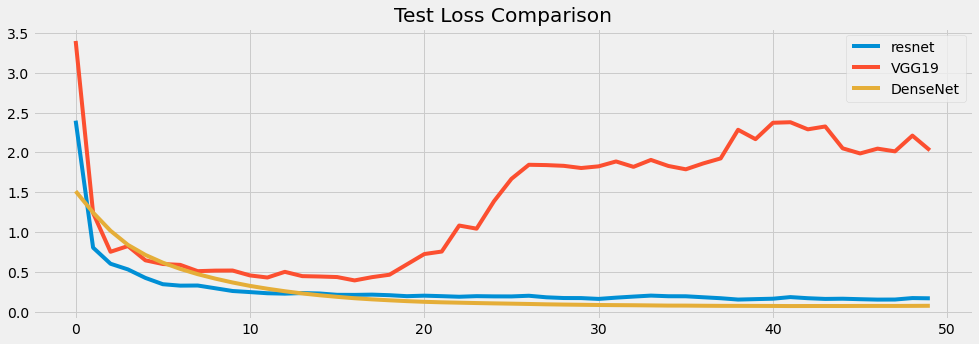

In [25]:
plt.figure(figsize=(15,5))
plt.title("Test Loss Comparison")
plt.plot(history_res.history["val_loss"],label="resnet")
plt.plot(history_vgg.history["val_loss"],label="VGG19")
plt.plot(history_dense.history["val_loss"],label="DenseNet")
plt.legend()
plt.show()

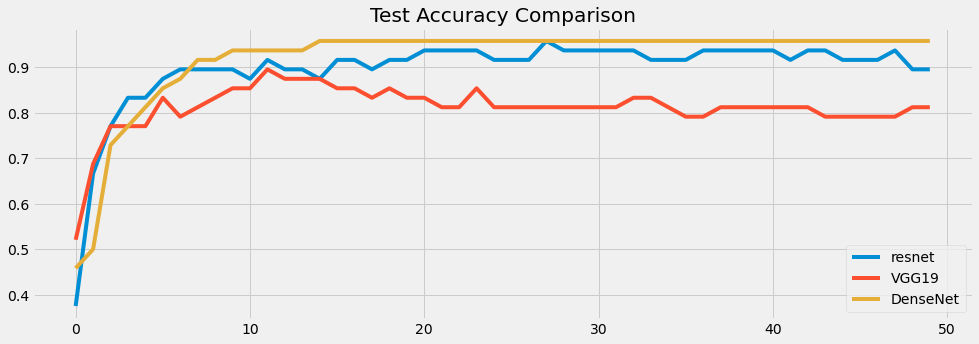

In [21]:
plt.figure(figsize=(15,5))
plt.title("Test Accuracy Comparison")
plt.plot(history_res.history["val_accuracy"],label="resnet")
plt.plot(history_vgg.history["val_accuracy"],label="VGG19")
plt.plot(history_dense.history["val_accuracy"],label="DenseNet")
plt.legend()
plt.show()

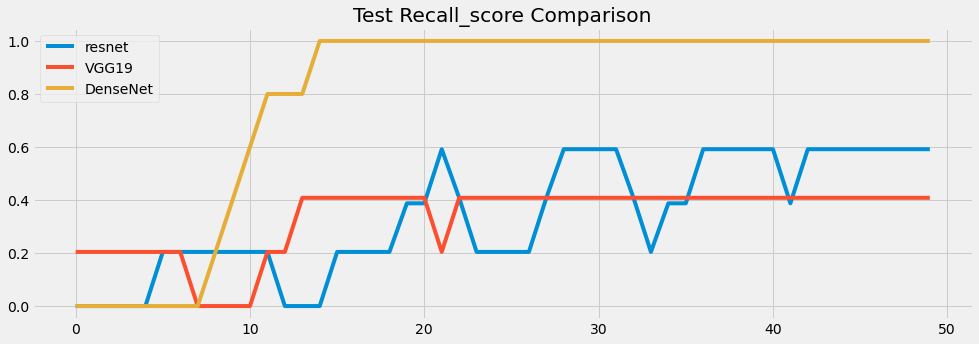

In [22]:
plt.figure(figsize=(15,5))
plt.title("Test Recall_score Comparison")
plt.plot(history_res.history["val_recall"],label="resnet")
plt.plot(history_vgg.history["val_recall"],label="VGG19")
plt.plot(history_dense.history["val_recall"],label="DenseNet")
plt.legend()
plt.show()

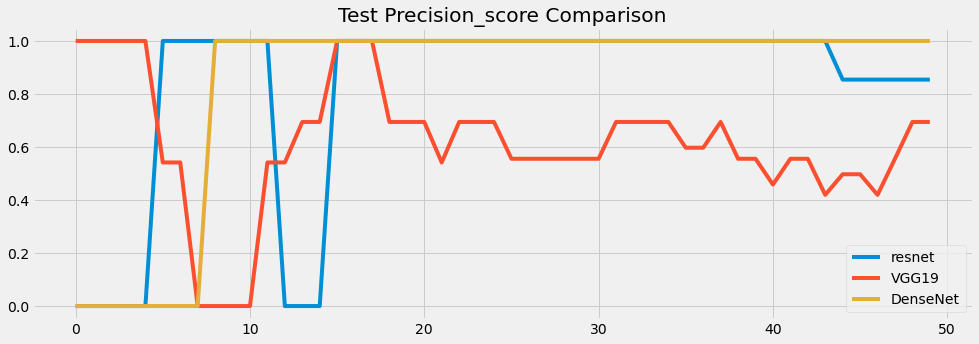

In [23]:
plt.figure(figsize=(15,5))
plt.title("Test Precision_score Comparison")
plt.plot(history_res.history["val_precision"],label="resnet")
plt.plot(history_vgg.history["val_precision"],label="VGG19")
plt.plot(history_dense.history["val_precision"],label="DenseNet")
plt.legend()
plt.show()

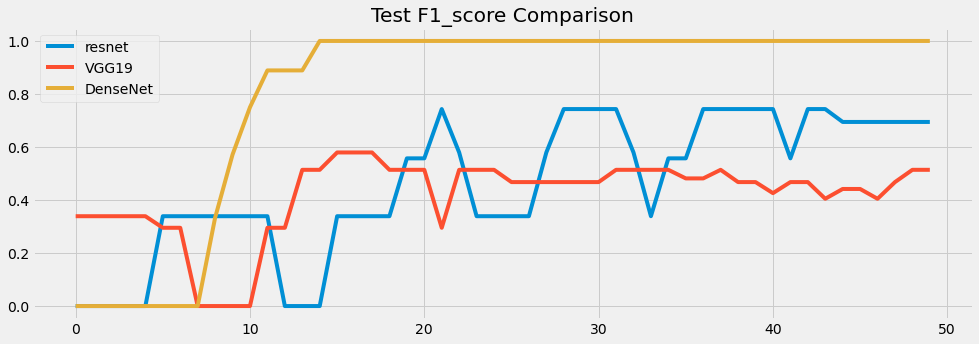

In [24]:
plt.figure(figsize=(15,5))
plt.title("Test F1_score Comparison")
plt.plot(history_res.history["val_f1_score"],label="resnet")
plt.plot(history_vgg.history["val_f1_score"],label="VGG19")
plt.plot(history_dense.history["val_f1_score"],label="DenseNet")
plt.legend()
plt.show()